# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

Загрузим все необходимые библиотеки.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer
import seaborn as sns
from sklearn.utils import shuffle
import catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

In [5]:
import warnings
warnings.filterwarnings('ignore')

Загрузим исходные датасеты и запишем их в общий список для удобного обращения.

In [6]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

all_df = [df_train, df_test, df_full]

Просмотрим информацию об исходных таблицах.

In [ ]:
for i in all_df:
    print(i.info(5))
    print('='*60)
    print()

Полный датасет состоит из 22716 строк (тренировочный и тестовый являются его частями).
Во всех таблицах присутсвуют пропуски. Т.к. обработка руды - непрерывный процесс, а датасеты отсортированы по времени, то логично предположить, что в соседних строках данные будут схожими. Поэтому заполним пропуски в данных методом *ffill*.

In [8]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. 

-	C — доля золота в концентрате после флотации/очистки;
-	F — доля золота в сырье/концентрате до флотации/очистки;
-	T — доля золота в отвальных хвостах после флотации/очистки.

In [9]:
def recovery(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    r = row['rougher.output.recovery']
    try:
        rec = abs((c * (f - t)) / (f * (c - t)) * 100)
        if rec >= 100:
            rec = 100
    except:
        rec = r           
    return rec

df_train['rougher.output.recovery_c'] = df_train.apply(recovery, axis=1)

Найдём MAE между нашими расчётами и значением признака. 

In [10]:
df_train['dif'] = abs(df_train['rougher.output.recovery_c'] - df_train['rougher.output.recovery'])
mae = df_train['dif'].mean()
mae

1.7932836524677727

Среднее отклонение очень маленькое, поэтому можно считать, что эффективность обогащения рассчитана правильно.

Проанализируем признаки, недоступные в тестовой выборке. 

Для начала выведем список этих признаков.

In [8]:
df_full.columns[~df_full.columns.isin(df_test.columns)]

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

Все отсутствующие в тестовой выборке параметры относятся к параметрам продукта или к расчетным характеристикам.

Создадим набор данных, который в последующем удалим перед обучением модели.

In [9]:
df_new = df_full.drop(df_full.columns[df_full.columns.isin(df_test.columns)], axis=1)

Для проверки моделей на тестовой выборке нам не хватает значений эффективности после флотации и окончательной эффективности, поэтому добавим эти столбцы из общего датасета в тестовый, индексом послужит дата.

In [10]:
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date')

### Вывод.

В качестве исходных данных нам было предоставлено 3 датасета. В них были заполнены пропуски. Проверен расчет эффективности обогащения для этапа флотации. Также датасеты были предварительно подготовлены к последующему обучению моделей.

# 2. Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [11]:
def print_hist(round):
    col_au = round + '.output.concentrate_au'
    col_ag = round + '.output.concentrate_ag'
    col_pb = round + '.output.concentrate_pb'
    
    plt.figure(figsize=[12, 8])
    
    sns.distplot(df_train[col_au], label='Au')
    sns.distplot(df_train[col_ag], label='Ag')
    sns.distplot(df_train[col_pb], label='Pb')
    
    plt.xlabel('Концентрация')
    plt.legend()
    plt.show()

                                Концентрация металлов после флотации


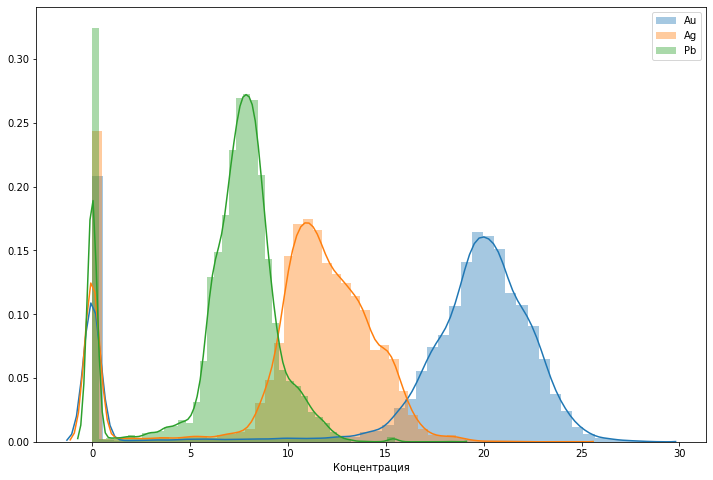

In [12]:
print(' '*32 + 'Концентрация металлов после флотации')
print_hist('rougher')

                           Концентрация металлов после первичной очистки


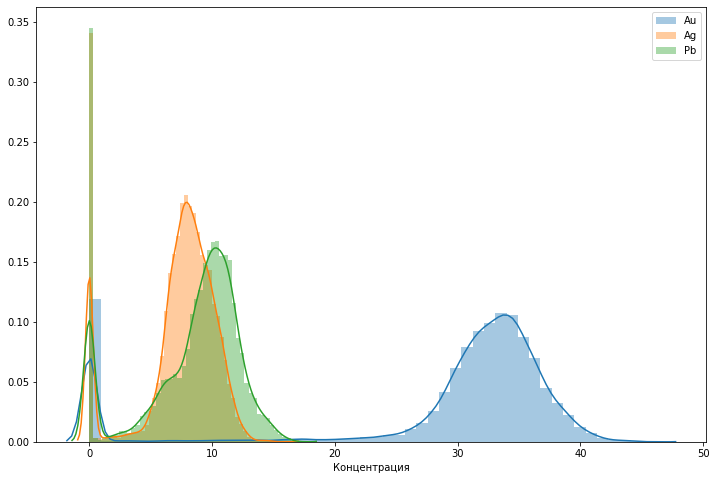

In [13]:
print(' '*27 + 'Концентрация металлов после первичной очистки')
print_hist('primary_cleaner')

                                 Финальная концентрация металлов


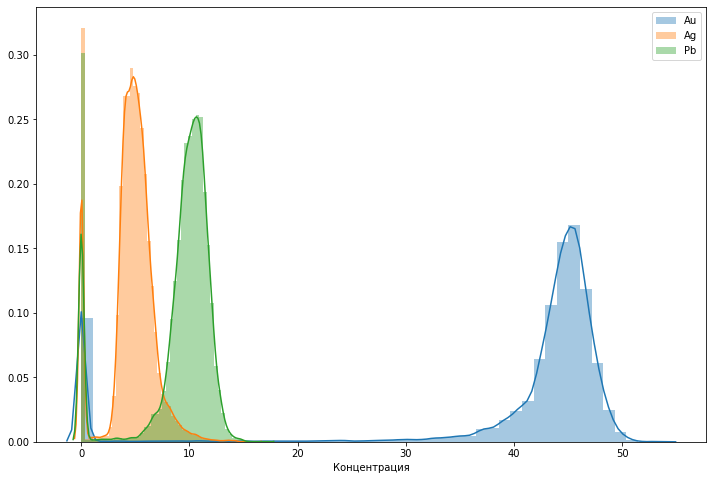

In [14]:
print(' '*33 + 'Финальная концентрация металлов')
print_hist('final')

### Вывод.

По данным графикам можно заметить, как с каждым этапом увеличивается концентрация золота и уменьшается - остальных металлов.

Однако, на всех графиках большое кол-во околонулевых значений, что кажется подозрительным - обработаем их в последующем.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 

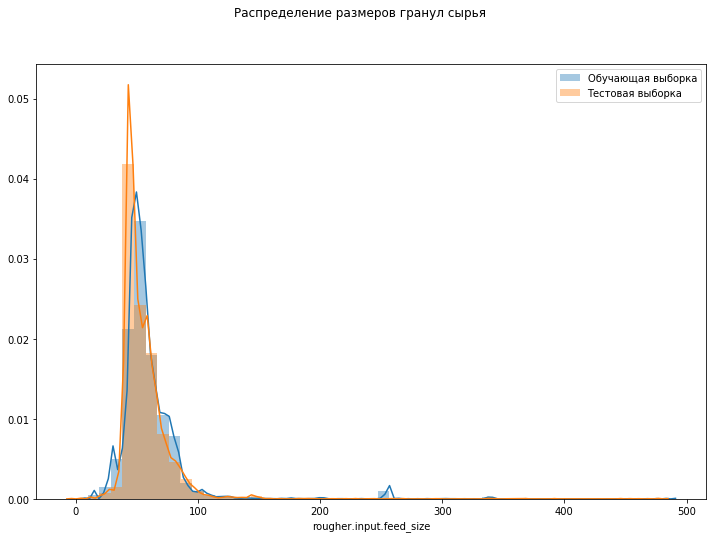

In [15]:
plt.figure(figsize=[12, 8])
sns.distplot(df_train['rougher.input.feed_size'], label='Обучающая выборка')
sns.distplot(df_test['rougher.input.feed_size'], label='Тестовая выборка')
plt.suptitle('Распределение размеров гранул сырья')
plt.legend()
plt.show()

In [16]:
df_train['rougher.input.feed_size'].describe()

count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [17]:
df_test['rougher.input.feed_size'].describe()

count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher.input.feed_size, dtype: float64

Распределения размеров гранул сырья близки для обеих выборок, поэтому мы можем позволить обучать и тестировать модель на этих данных.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [18]:
df_train['rougher.concentrate'] = (df_train['rougher.output.concentrate_au'] +
                                  df_train['rougher.output.concentrate_ag'] +
                                  df_train['rougher.output.concentrate_pb'] +
                                  df_train['rougher.output.concentrate_sol'])

df_train['primary_cleaner.concentrate'] = (df_train['primary_cleaner.output.concentrate_au'] +
                                          df_train['primary_cleaner.output.concentrate_ag'] +
                                          df_train['primary_cleaner.output.concentrate_pb'] +
                                          df_train['primary_cleaner.output.concentrate_sol'])

df_train['final.concentrate'] = (df_train['final.output.concentrate_au'] +
                                  df_train['final.output.concentrate_ag'] +
                                  df_train['final.output.concentrate_pb'] +
                                  df_train['final.output.concentrate_sol'])

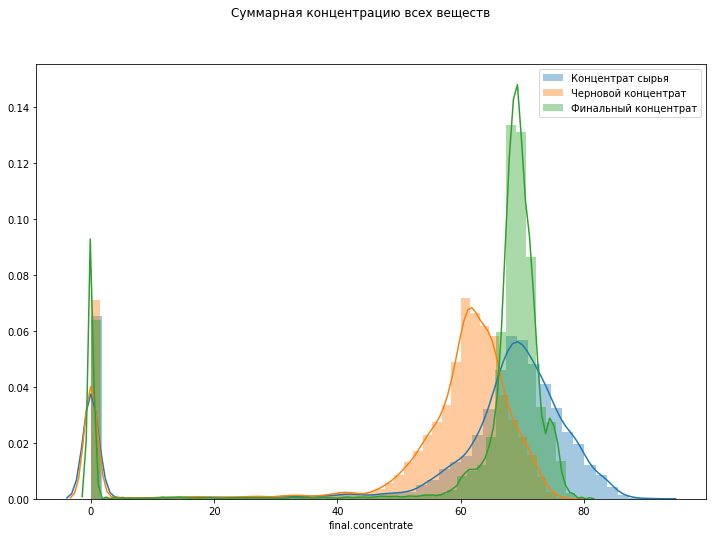

In [19]:
plt.figure(figsize=[12, 8])
sns.distplot(df_train['rougher.concentrate'], label='Концентрат сырья')
sns.distplot(df_train['primary_cleaner.concentrate'], label='Черновой концентрат')
sns.distplot(df_train['final.concentrate'], label='Финальный концентрат')
plt.suptitle('Суммарная концентрацию всех веществ')
plt.legend()
plt.show()

Большое кол-во нулевых значений на суммарной концентрации веществ - это те данные, которые явно не помогут в обучении модели, поэтому удалим их.

In [20]:
ind_to_drop = df_train[df_train['final.concentrate'] == 0].index
df_train = df_train.drop(ind_to_drop)

### Вывод.

Проанализировав концентрацию металлов на трех этапах очистки, мы увидели закономерное увеличение концентрации золота и странные околонулевые значения, которые впоследствии были также обнаружены при анализе суммарных концентраций всех веществ. Причиной возникновения этих данных может быть техническая ошибка или это просто попадание бесполезной руды на обогащение (что, вероятно, нужно проверить,  дабы избежать лишних затрат). В любом случае для последующего построения модели нам эти данные не понадобятся.

# 3. Модель

Напишим функцию для вычисления итоговой sMAPE.

In [21]:
def count_smape(prediction, target):
    smape = 2 *np.mean(abs(target - prediction) / (abs(target) + abs(prediction))) * 100
    return smape

Итоговая sMAPE состоит из двух величин:
-	эффективность обогащения чернового концентрата rougher.output.recovery (25%)
-	эффективность обогащения финального концентрата (75%)

In [22]:
def result_smape(r_prediction, f_prediction):
    smape_rougher = count_smape(r_prediction, r_test_target)
    smape_final = count_smape(f_prediction, f_test_target)
    final_smape = 0.25*smape_rougher + 0.75*smape_final
    return final_smape

Для обучения модели по нестандартной метрике создадим свой скорер.

In [23]:
smape_score = make_scorer(count_smape, greater_is_better=False)

Для тренировочной выборки выделим ключевые признаки для обоих этапов

In [24]:
r_train_target = df_train['rougher.output.recovery']
f_train_target = df_train['final.output.recovery']

Теперь удалим из нее отсутсвующие в тестовой выборке признаки (в df_new они все собраны), а также оставшиеся ненужные признаки.

In [25]:
df_train = df_train.drop(df_new.columns, axis=1)
df_train = (df_train.drop(
    ['date', 'rougher.output.recovery_c', 'dif', 'rougher.concentrate', 'primary_cleaner.concentrate', 'final.concentrate'], 
    axis=1))

Проведем тоже самое для тестовой выборки и проверим размеры получившихся признаковых пространств.

In [26]:
r_test_target = df_test['rougher.output.recovery']
f_test_target = df_test['final.output.recovery']
test = df_test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

print(df_train.shape, '|', r_train_target.shape)
print(df_test.shape, ' | ', r_test_target.shape)

(15540, 52) | (15540,)
(5856, 55)  |  (5856,)


Т.к. необходимо предсказывать сразу два ключевых признака, то обучать будем по 2 модели.

Первая модель - **модель градиентного бустинга**.

In [43]:
r_model = catboost.CatBoostRegressor(iterations=100, learning_rate=0.05, random_seed=63)
f_model = catboost.CatBoostRegressor(iterations=100, learning_rate=0.05, random_seed=63)

In [44]:
r_model.fit(df_train, r_train_target, verbose=False)
f_model.fit(df_train, f_train_target, verbose=False)

In [45]:
r_prediction = r_model.predict(test)
f_prediction = f_model.predict(test)

result_smape(r_prediction, f_prediction)

12.065829730060493

проверим степени влияния каждого признака на итоговое решение.

In [46]:
importances = r_model.feature_importances_

indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), '--', df_train.columns[f])

Feature ranking:
1. feature 12 (7.033870) -- primary_cleaner.input.sulfate
2. feature 20 (6.785397) -- primary_cleaner.input.depressant
3. feature 19 (5.825325) -- primary_cleaner.input.feed_size
4. feature 0 (5.450414) -- primary_cleaner.input.xanthate
5. feature 21 (5.185797) -- primary_cleaner.state.floatbank8_a_air
6. feature 15 (5.084306) -- primary_cleaner.state.floatbank8_a_level
7. feature 28 (4.610585) -- primary_cleaner.state.floatbank8_b_air
8. feature 16 (4.459330) -- primary_cleaner.state.floatbank8_b_level
9. feature 3 (4.424850) -- primary_cleaner.state.floatbank8_c_air
10. feature 46 (4.164503) -- primary_cleaner.state.floatbank8_c_level
11. feature 42 (4.061222) -- primary_cleaner.state.floatbank8_d_air
12. feature 18 (3.525710) -- primary_cleaner.state.floatbank8_d_level
13. feature 17 (3.114867) -- rougher.input.feed_ag
14. feature 48 (2.854127) -- rougher.input.feed_pb
15. feature 26 (2.499123) -- rougher.input.feed_rate
16. feature 6 (2.423663) -- rougher.input.fee

Уберем признаки с влиянием менее 0.1%

In [47]:
columns_to_drop = ['secondary_cleaner.state.floatbank4_b_level',
                             'secondary_cleaner.state.floatbank5_a_air',
                             'secondary_cleaner.state.floatbank5_a_level',
                             'secondary_cleaner.state.floatbank5_b_air',
                             'secondary_cleaner.state.floatbank5_b_level',
                             'secondary_cleaner.state.floatbank6_a_air',
                             'secondary_cleaner.state.floatbank6_a_level',
                             'secondary_cleaner.state.floatbank4_b_air',
                             'secondary_cleaner.state.floatbank4_a_level',
                             'secondary_cleaner.state.floatbank4_a_air'] 
df_train_upd = df_train.drop(columns_to_drop, axis=1)
test_upd = test.drop(columns_to_drop, axis=1)

Обучим модель на обновленных данных и проверим результат.

In [48]:
r_model.fit(df_train_upd, r_train_target, verbose=False)
f_model.fit(df_train_upd, f_train_target, verbose=False)

In [49]:
r_prediction = r_model.predict(test)
f_prediction = f_model.predict(test)

result_smape(r_prediction, f_prediction)

11.833384518180358

С обновленными данными результат стал лучше, ключевая метрика sMAPE понизилась.

Проведем кросс-валидацию, чтобы оценить ее качество.

In [ ]:
print(cross_val_score(r_model, df_train_upd, r_train_target, scoring=smape_score, cv=5).mean())

Средняя sMAPE = 12.15. (результат выполнения ячейки скрыт)

Проверим нашу модель на адекватность, сравнив с константным предсказанием, в качестве которого возьмем среднее арифметическое.

In [64]:
r_prediction_const = pd.Series(r_test_target.mean(), index=r_test_target.index)
f_prediction_const = pd.Series(f_test_target.mean(), index=f_test_target.index)

result_smape(r_prediction_const, f_prediction_const)

12.303118340325145

Результат константной модели - sMAPE = 12.30, что говорит нам о том, что наша модель работает не намного лучше, чем простое предсказание среднего. 

Попробуем улучшить модели, подобрав параметры с помощью  *GridSearchCV* (встроенная кросс-валидация позволяет нам не делать дополнительных операций)

In [53]:
r_model_2 = catboost.CatBoostRegressor(random_seed=63)
param_grid = {'depth'         : [6,8,10],
                'learning_rate' : [0.01, 0.05, 0.1],
                'iterations'    : [30, 50, 100]
                 }
grid_2 = GridSearchCV(estimator=r_model_2, param_grid = param_grid, cv = 3, scoring=smape_score)
grid_2.fit(df_train_upd, r_train_target) 

0:	learn: 17.5552200	total: 6.66ms	remaining: 193ms
1:	learn: 17.5046924	total: 54.9ms	remaining: 768ms
2:	learn: 17.4581875	total: 153ms	remaining: 1.38s
3:	learn: 17.4085868	total: 251ms	remaining: 1.63s
4:	learn: 17.3604803	total: 269ms	remaining: 1.34s
5:	learn: 17.3080691	total: 360ms	remaining: 1.44s
6:	learn: 17.2573168	total: 456ms	remaining: 1.5s
7:	learn: 17.2092069	total: 551ms	remaining: 1.51s
8:	learn: 17.1602366	total: 649ms	remaining: 1.51s
9:	learn: 17.1147598	total: 743ms	remaining: 1.49s
10:	learn: 17.0703497	total: 758ms	remaining: 1.31s
11:	learn: 17.0224985	total: 850ms	remaining: 1.27s
12:	learn: 16.9737563	total: 945ms	remaining: 1.24s
13:	learn: 16.9246321	total: 1.04s	remaining: 1.19s
14:	learn: 16.8754587	total: 1.06s	remaining: 1.06s
15:	learn: 16.8347753	total: 1.15s	remaining: 1.01s
16:	learn: 16.7912614	total: 1.24s	remaining: 950ms
17:	learn: 16.7527959	total: 1.33s	remaining: 889ms
18:	learn: 16.7147303	total: 1.35s	remaining: 784ms
19:	learn: 16.6688500

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb23cf53750>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(count_smape, greater_is_better=False),
             verbose=0)

In [57]:
f_model_2 = catboost.CatBoostRegressor(random_seed=63)
param_grid = {'depth'         : [6,8,10],
                'learning_rate' : [0.01, 0.05, 0.1],
                'iterations'    : [30, 50, 100]
                 }
grid_2f = GridSearchCV(estimator=f_model_2, param_grid = param_grid, cv = 3, scoring=smape_score)
grid_2f.fit(df_train_upd, f_train_target) 

0:	learn: 12.4838804	total: 10.9ms	remaining: 316ms
1:	learn: 12.4315196	total: 96.7ms	remaining: 1.35s
2:	learn: 12.3815542	total: 191ms	remaining: 1.72s
3:	learn: 12.3296644	total: 207ms	remaining: 1.35s
4:	learn: 12.2784293	total: 303ms	remaining: 1.51s
5:	learn: 12.2305371	total: 402ms	remaining: 1.61s
6:	learn: 12.1802445	total: 493ms	remaining: 1.62s
7:	learn: 12.1293056	total: 592ms	remaining: 1.63s
8:	learn: 12.0797876	total: 605ms	remaining: 1.41s
9:	learn: 12.0320828	total: 698ms	remaining: 1.4s
10:	learn: 11.9851821	total: 799ms	remaining: 1.38s
11:	learn: 11.9380438	total: 885ms	remaining: 1.33s
12:	learn: 11.8895019	total: 907ms	remaining: 1.19s
13:	learn: 11.8459679	total: 998ms	remaining: 1.14s
14:	learn: 11.8009503	total: 1.09s	remaining: 1.09s
15:	learn: 11.7552509	total: 1.18s	remaining: 1.03s
16:	learn: 11.7108136	total: 1.28s	remaining: 977ms
17:	learn: 11.6652954	total: 1.37s	remaining: 914ms
18:	learn: 11.6226636	total: 1.4s	remaining: 808ms
19:	learn: 11.5804602	

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb23cf9f690>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(count_smape, greater_is_better=False),
             verbose=0)

In [65]:
r_prediction_2 = grid_2.predict(test)
f_prediction_2 = grid_2f.predict(test)

result_smape(r_prediction_2, f_prediction_2)

12.101566247526256

Результат стал лучше на 0.05%, не слишком много, но пока это лучший результат.

Попробуем обучить поочередно линейную регрессию, дерево решений и случайный лес.

**Линейная регрессия.**

In [68]:
r_model_lr = LinearRegression()
f_model_lr = LinearRegression()

r_model_lr.fit(df_train_upd, r_train_target)
f_model_lr.fit(df_train_upd, f_train_target)

r_prediction_lr = r_model_lr.predict(test_upd)
f_prediction_lr = f_model_lr.predict(test_upd)

result_smape(r_prediction_lr, f_prediction_lr)

13.230140607450856

Линейная регрессия не может обеспечить адекватную ключевую метрику.

С помощью GridSearchCV обучим **Дерево решений.**

In [60]:
param_grid = {'max_depth' : range(2, 8)}
gs = GridSearchCV(DecisionTreeRegressor(random_state=12345), param_grid=param_grid, scoring=smape_score)

In [61]:
r_gs_tree = gs.fit(df_train, r_train_target)
f_gs_tree = gs.fit(df_train, f_train_target)

r_prediction_tree = r_gs_tree.predict(test)
f_prediction_tree = f_gs_tree.predict(test)

result_smape(r_prediction_tree, f_prediction_tree)

23.586819673037347

Результат также не проходит критерий адекватности.

**Случайный лес.**

In [66]:
param_grid = {'max_depth' : [md for md in range(2, 8)],
             'n_estimators': [n for n in range(5, 51, 5)]}
gs_rf = GridSearchCV(RandomForestRegressor(random_state=12345), param_grid=param_grid, scoring=smape_score)

In [67]:
r_gs_rf = gs_rf.fit(df_train, r_train_target)
f_gs_rf = gs_rf.fit(df_train, f_train_target)

r_prediction_rf = r_gs_rf.predict(test) 
f_prediction_rf = f_gs_rf.predict(test)

result_smape(r_prediction_rf, f_prediction_rf)

16.450702114505088

Случайный лес тоже не смог достичь минимально необходимого результата.

# Вывод.

- данные загружены и обработаны, заполнены пропуски;
- проведена проверка расчета эффективности обогащения;
- проведен анализ данных:
    - рассмотрено изменение концентрации металлов на различных этапах очистки;
    - проведено сравнение распределений размеров гранул сырья на обучающей и тестовой выборке;
    - исследована суммарная концентрация всех веществ и удалены аномальные значения;
- построено несколько моделей, ключевой метрикой которых, являлась sMAPE;
- найдена лучшая модель на тестовой выборке (с учетом кросс-валидации).